# Práctica 2
### Autores:
 - Martín de las Heras
 - Daniel Serrano
 
# Introducción

En la constante búsqueda de mejorar los diagnósticos médicos y acelerar los procesos de atención a pacientes, la inteligencia artificial ha emergido como una herramienta revolucionaria. Dentro de este campo, las redes neuronales convolucionales (CNNs) han demostrado ser particularmente eficaces para analizar y predecir condiciones médicas a partir de imágenes radiográficas. Este documento presenta una práctica innovadora donde se implementan CNNs para la detección y diagnóstico de la neumonía en pacientes, utilizando radiografías de tórax.

Las CNNs, con su capacidad para identificar patrones complejos y aprender de grandes conjuntos de datos, ofrecen una solución prometedora para superar este desafío. Al entrenar una red neuronal con miles de imágenes radiográficas etiquetadas, se puede enseñar a la máquina a distinguir entre radiografías normales y aquellas que presentan signos de neumonía.

La introducción de esta tecnología no solo promete aumentar la precisión de los diagnósticos sino también proporcionar una herramienta de apoyo para los radiólogos, permitiéndoles confirmar sus evaluaciones con mayor confianza y eficiencia. Este avance representa un paso significativo hacia la automatización del diagnóstico médico, abriendo la puerta a un futuro donde la inteligencia artificial y la medicina trabajan de la mano para salvaguardar la salud humana.

En esta práctica, continuaremos con el camino iniciado en la práctica anterior, en la cual empleamos redes neuronales profundas para hacer la clasificación. En este caso, optaremos por una medidas más especializadas para este tipo de problemas, ambas explicadas en clase.


---

# Preparación de los datos

En primer lugar, procederemos a leer los datos y prepararlos de cara a las ejecuciones de los modelos. Esta parte del código es idéntica al de la práctica anterior, ya que se trata del mismo dataset y las mismas distribuciones, para poder asegurar que la comparación final entre los resultados es objetiva y no influenciada por la aleatoriedad.

In [1]:
# Import os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
# Kernel Intilizer 
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, Adamax
# PreTrained Model
from tensorflow.keras.applications import *
from tensorflow.keras.applications import Xception
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove 
import warnings 
warnings.filterwarnings("ignore")
import keras_tuner

2024-04-27 15:39:23.868045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 15:39:23.868144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 15:39:23.983430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Cargamos el conjunto de entrenamiento de Kaggle y creamos el *dataframe* que utilizaremos:

In [2]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath, name = 'filepath')
label_path_series = pd.Series(label, name = 'label')
df_train = pd.concat([file_path_series, label_path_series], axis = 1)

Mostramos unas pocas filas por pantalla:

In [3]:
df_train.head()

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


Repetimos para el conjunto de prueba:

In [4]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath, name = 'filepath')
label_path_series = pd.Series(label, name = 'label')
df_test = pd.concat([file_path_series, label_path_series], axis = 1)

Y de la misma manera, imprimimos por pantalla una muestra del conjunto de prueba:

In [5]:
df_train.sample(5)

,filepath,label
4022,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
269,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2778,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3455,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3890,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


Imprimimos por pantalla las dimensiones de los conjuntos de entrenamiento y prueba:

In [6]:
print(f"Las dimensiones del conjunto de entrenamiento son: {df_train.shape}")
print(f"Las dimensiones del conjunto de prueba son: {df_test.shape}")

Las dimensiones del conjunto de entrenamiento son: (5216, 2)
Las dimensiones del conjunto de prueba son: (624, 2)


---

## Creamos los *datasets* de entrenamiento, validación y test

In [7]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

IMAGE_SIZE = (256,256)

print('Imágenes de entrenamiento:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Imágenes de validación:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Imágenes de prueba:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Imágenes de entrenamiento:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Imágenes de validación:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Imágenes de prueba:
Found 624 files belonging to 2 classes.


## Codificar etiquetas

A continuación, utilizaremos el *LabelEncoder* para codificar las categorías de las imágenes:

In [8]:
train_labels = train_ds.class_names
validation_labels = validation_ds.class_names
test_labels = test_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA'] 

label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

De la misma manera, imprimios por pantalla las dimensiones de las entradas del conjunto de entrenamiento:

In [9]:
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


## Normalizar Valores Pixel

Normalizamos los valores de los pixels dividiendo por 255:

In [10]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

## Métricas conjuntos

Hacemos un estudio previo del conjunto de datos de entrenamiento para ver qué es necesario tener en cuenta de cara al procesado de los mismos. Para ello contamos las ocurrencias de cada etiqueta en el *dataframe* y graficamos los resultados.

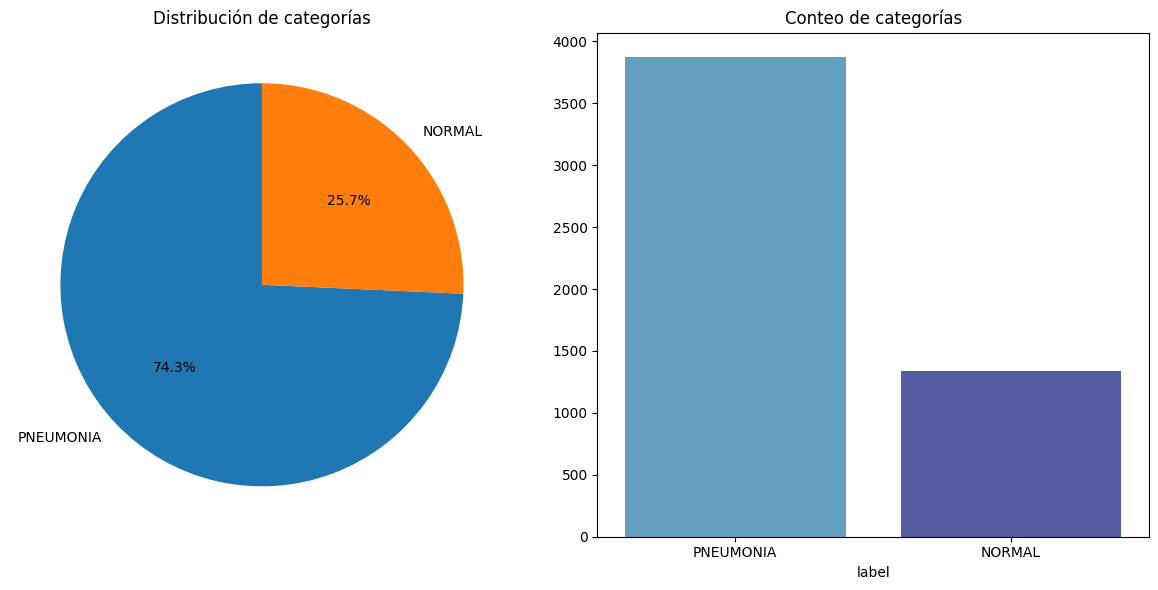

In [11]:
count = df_train['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("icefire")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribución de categorías')

sns.barplot(x=count.index, y=count.values, ax=axs[1])
axs[1].set_title('Conteo de categorías')

plt.tight_layout()
plt.show()

Repetimos el estudio con el conjunto de datos de prueba.

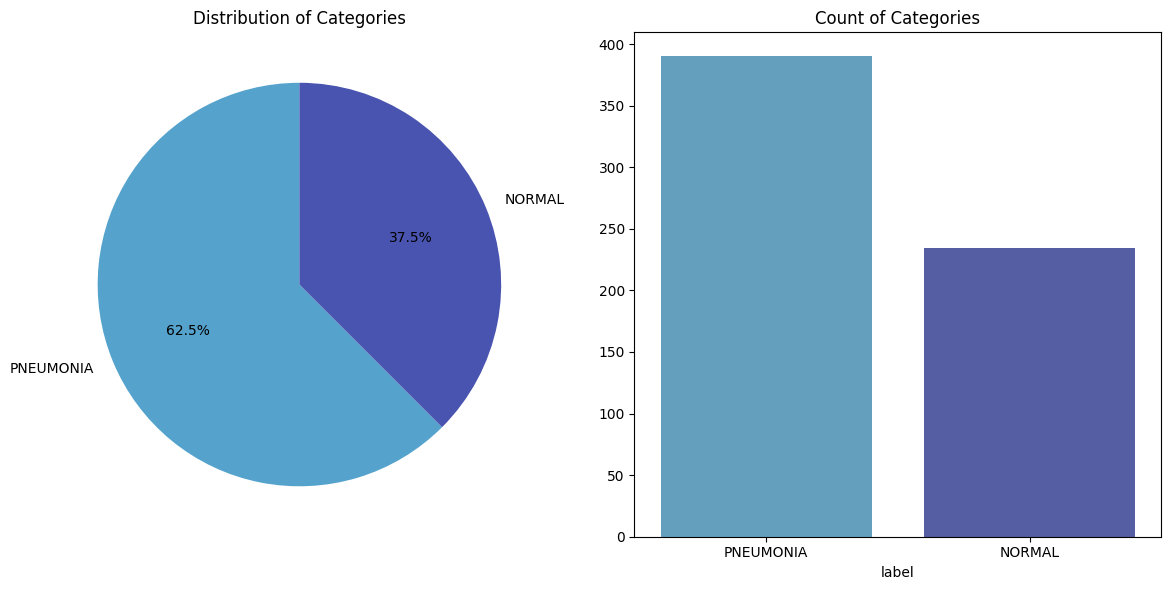

In [12]:
count = df_test['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("icefire")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1])
axs[1].set_title('Count of Categories')

plt.tight_layout()
plt.show()

---
## Visualización imágenes de entrenamiento

Extraemos y mostramos por pantalla 5 imágenes del conjunto de entrenamiento. Para ello, en primer lugar, definimos una función de visualización.

In [13]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    
    num_images = min(num_images, len(image_filenames))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    
    plt.tight_layout()
    plt.show()

## NORMAL Imágenes

Imprimimos imágenes calificadas como *NORMAL*

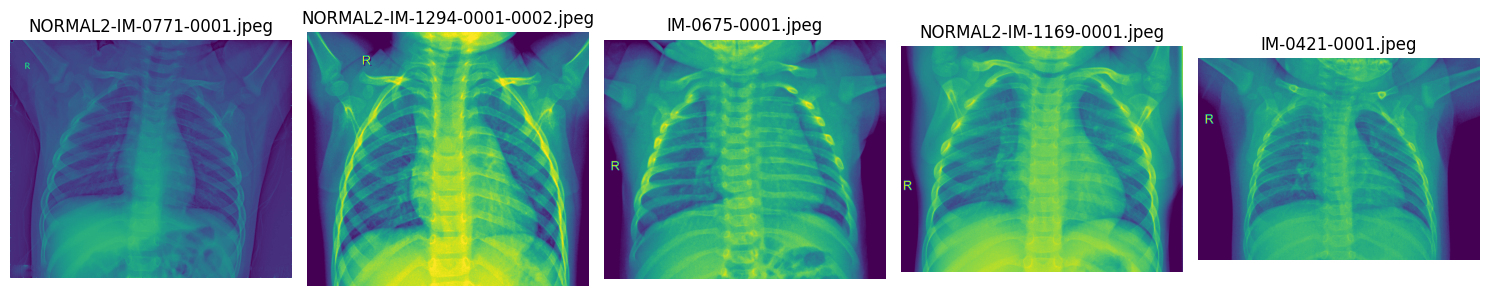

In [14]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

visualize_images(path_to_visualize, num_images=5)

## PNEUMONIA Imágenes

Imprimimos imágenes calificadas como *PNEUMONIA*

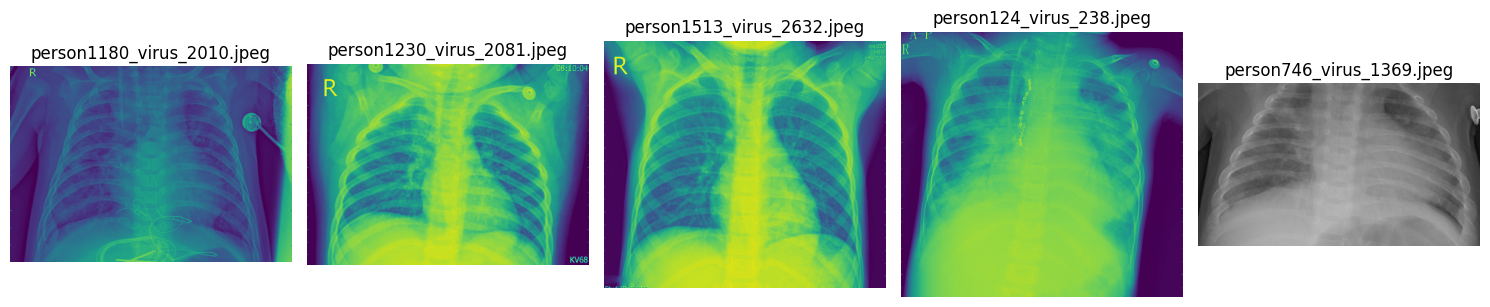

In [15]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

visualize_images(path_to_visualize, num_images=5)

---
# Definición de los modelos

En esta práctica, como continuación de la práctica anterior, tomaremos dos nuevos enfoques vistos en clase de cara a la clasificación:
 1. Red Neuronal Convolucional
 2. *Transfer Learning*

## 1. Red Neuronal Convolucional

En primer lugar, tomaremos una red neuronal convolucional.

Las redes neuronales convolucionales (CNNs) son ideales para clasificar imágenes, incluyendo radiografías, debido a su capacidad para procesar datos visuales y reconocer patrones complejos. Aquí te explico algunas razones clave:

 - **Extracción de Características**: Las CNNs son capaces de detectar automáticamente características importantes en las imágenes, como bordes, texturas y formas específicas.
 - **Jerarquía de Aprendizaje**: Pueden aprender jerarquías de características; las capas más bajas pueden reconocer características simples, y las capas más altas pueden identificar elementos más complejos, como la estructura de un órgano.
 - **Reducción de Dimensionalidad**: Utilizan operaciones de convolución y agrupación para reducir la dimensionalidad de las imágenes, lo que permite un procesamiento más eficiente sin perder información crítica.
 - **Invariancia Espacial**: Tienen la capacidad de reconocer patrones independientemente de su posición en la imagen, lo cual es crucial para la clasificación médica donde la orientación de una característica puede variar.
 - **Automatización y Precisión**: Permiten la clasificación automática y precisa de radiografías en categorías específicas, lo que puede mejorar la eficiencia y la precisión del diagnóstico.

En resumen, las CNNs son una herramienta poderosa en el campo de la visión por computadora y son especialmente útiles en la clasificación de imágenes médicas debido a su capacidad para aprender y reconocer patrones complejos de manera eficiente. Esto las hace muy valiosas para asistir en el diagnóstico médico y en la mejora de los servicios de salud.

#### Esta red se compone de diferentes partes:

Primero se encuentra la parte de convoluciones. Se encunetra en la entrada de la red, y su funcion principal es la extraccion de caracteristicas de la imagen, obteniendo cada vez más caracteristicas segun apilamos las capas. Nos da información de la estructura y los patrones de la imagen, diferenciadolas con un gran potencial de cualquier otro modelo, ya que no entienden las estruturas en si. En nuestra red hemos optador por usar 5 capas convolucionales, cada una de ellas seguida de otra Maxpooling2D, que se utiliza para reducir la imagen a la mitad. Esta comprobado de usar maxpooling a la salida de capas convolucionales mejora considerablemente el aprendizaje.

En la segunda parte nos encontramos con la arquitectula de una MLP (MultiLayer Perceptron), la cual nos permitirá realizar nuestra tarea de clasificación, usando como entradas las salidas de las capas convolucionales. Esta MLP esta compuesta por dos capas densas de 220 y 60 neuronas con un *dropout* de 0.45 y 0.25 respectivamente. La salida de la red es una capa densa de una sola neurona con activacion *sigmoid* (dandonos la probabilidad entre 0 y 1 sobre pertenecer a la clase positiva), la cual su finalidad es clasificar entre 0 y 1, ya que nuestro clasificador es binario. Se ha utilizado una funcion de activacion *relu*, en las capas ocultas, debido que es una de las que mejores funcionan en el entremiento. El uso de dropout se utiliza para el overoverfitting, y obliga a todas las neuronas a que aprendan y participen.

Para poder unir estas dos "partes", necesitamos que tanto la salida de las convoluciones y la entrada al MLP, tengan el mismo formato. Para ello utilizados una "capa" llamada "Flatten", que toma esta salida bidimensional de las capas convolucionales y la convierte en un vector unidimensional, desenrollando esencialmente la matriz en una única dimensión. Apartir de esta capa se pierde cualquier información de la posición espacial, y la red solo ve una lista plana de números.

Como parametros del entrenamiento hemos ultilizado como optimizador *Adamax*, después de un proceso de ensayo y error, con diferentes optimizadores, entre ellos Adam. Suele ir mejor para modelos grandes con muchos parametros y capas.

Como función de perdida hemos utilizado la *Binary Cross Entropy*. Siempre se utiliza esta métrica en problemas de clasificación binaria es porque está diseñada específicamente para clasificación binaria.

Por ultimo, para evaluear el modelo hemos optado por usar el *acurracy*. Esta calcula la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas. Se utiliza en problemas de clasificación binaria porque proporciona una visión general del rendimiento del modelo al clasificar correctamente tanto las muestras positivas como las negativas.

### 1.1 Creamos la arquitectura del modelo

Esquema de la Aquitectura utilizada
- 5 Capas convolucionales bidimensionales con activacion *relu*.
- 5 Capas MaxPooling bidimensional con kernel 2x2.
- Capa Flatten
- 2 Densas con ativación *relu* y dropout.
- 1 Capa densa de salida con activación *sigmoid* para la clasificación.

In [16]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25)) 

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25)) 

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,303,937 (24.05 MB)

 Trainable params: 6,303,937 (24.05 MB)

 Non-trainable params: 0 (0.00 B)

### 1.2 Compilar y Entrenar

Definimos un *early stopping* de cara al entrenamiento de la red neuronal, guardando siempre la mejor ejecución y definiendo una paciencia de 5 *epochs*.

A continuación, la entrenamos con el conjunto de entrenamiento validando con el de validación durante un máximo de 20 épocas:

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds,
                    epochs= 20,
                    validation_data = validation_ds,
                    callbacks = early_stopping);

Epoch 1/20


2024-04-27 15:39:58.698797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.22285, expected 4.50617
2024-04-27 15:39:58.698853: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 4.83523, expected 4.11855
2024-04-27 15:39:58.698862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.14347, expected 5.42679
2024-04-27 15:39:58.698871: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 5.72417, expected 5.00749
2024-04-27 15:39:58.698879: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.00776, expected 5.29109
2024-04-27 15:39:58.698886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 5.39609, expected 4.67941
2024-04-27 15:39:58.698894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 5.14673, expected 4.43005
2024-04-27 15:39:58.698901: E external/local_xla/

  4/147 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8301 - loss: 1.4677

I0000 00:00:1714232408.167188      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714232408.186920      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/147 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7522 - loss: 0.6752

2024-04-27 15:40:32.452750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64547: 4.71454, expected 4.06085
2024-04-27 15:40:32.452825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64694: 5.14582, expected 4.49213
2024-04-27 15:40:32.452836: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64801: 4.55823, expected 3.90454
2024-04-27 15:40:32.452844: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64926: 5.2221, expected 4.56841
2024-04-27 15:40:32.452852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64927: 5.37846, expected 4.72477
2024-04-27 15:40:32.452859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64970: 5.28086, expected 4.62717
2024-04-27 15:40:32.452867: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65055: 5.49753, expected 4.84384
2024-04-27 15:40:32.452875: 

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7525 - loss: 0.6732

2024-04-27 15:40:43.186401: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.79984, expected 5.93633
2024-04-27 15:40:43.186468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.88388, expected 6.02037
2024-04-27 15:40:43.186479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.1383, expected 6.2748
2024-04-27 15:40:43.186488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 6.87069, expected 6.00719
2024-04-27 15:40:43.186497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.19625, expected 5.33275
2024-04-27 15:40:43.186506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 7.51432, expected 6.65081
2024-04-27 15:40:43.186515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27: 7.48632, expected 6.62282
2024-04-27 15:40:43.186523: E external/local_xla/xla/

147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 249ms/step - accuracy: 0.7526 - loss: 0.6722 - val_accuracy: 0.9175 - val_loss: 0.2428
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9151 - loss: 0.2237 - val_accuracy: 0.9520 - val_loss: 0.1349
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9508 - loss: 0.1516 - val_accuracy: 0.9693 - val_loss: 0.0844
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9588 - loss: 0.1089 - val_accuracy: 0.9635 - val_loss: 0.1102
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9707 - loss: 0.0857 - val_accuracy: 0.9674 - val_loss: 0.1006
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9705 - loss: 0.0849 - val_accuracy: 0.9750 - val_loss: 0.0681
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9759 - loss: 0.0722 - val_accuracy: 0.9482 - val_loss: 0.1924
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9704 - loss: 0.0792 - val

### 1.3 Error de validación y precisión

Obtenemos el error sobre el conjunto de validación y su precisión sobre el mismo:

In [18]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print("Error de validación:", validation_loss)
print("Precisión:", validation_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9794 - loss: 0.0672
Error de validación: 0.05343565717339516
Precisión: 0.9827255010604858


Ahora, escogemos la época con mejor precisión y graficamos tanto la precisión como la función de pérdida de los conjuntos de entrenamiento y validación:

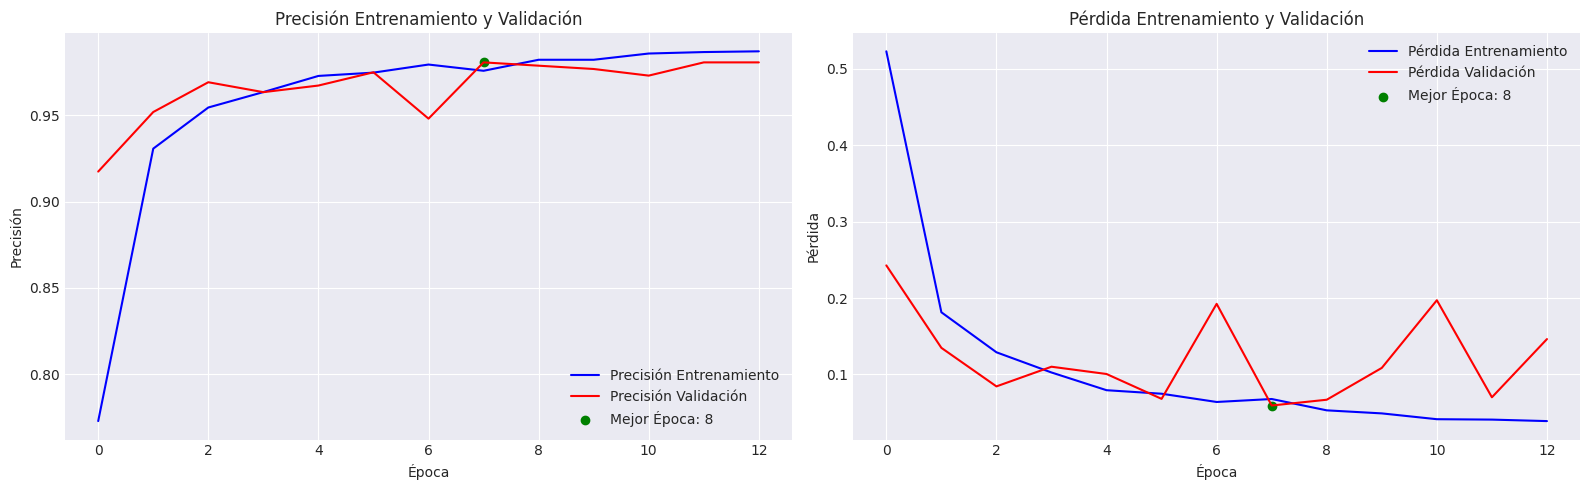

In [19]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Precisión Entrenamiento', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Precisión Validación', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Mejor Época: {best_epoch}')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Precisión')
axs[0].set_title('Precisión Entrenamiento y Validación')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Pérdida Entrenamiento', color='blue')
axs[1].plot(history.history['val_loss'], label='Pérdida Validación', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Mejor Época: {best_epoch}')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Pérdida')
axs[1].set_title('Pérdida Entrenamiento y Validación')
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.4 Predicciones del Modelo

Por último, tomamos una muestra de imágenes del conjunto de test e imprimimos por pantalla tanto las imágenes como las predicciones del modelo.

Para ello, definimos la misma función de la práctica anterior para que nos imprima por pantalla:

In [20]:
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 

2024-04-27 15:44:54.443805: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129032: 6.23419, expected 5.28448
2024-04-27 15:44:54.443850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129033: 6.10421, expected 5.15451
2024-04-27 15:44:54.443859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129034: 7.09771, expected 6.148
2024-04-27 15:44:54.443869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129035: 8.03191, expected 7.08221
2024-04-27 15:44:54.443876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129036: 7.06707, expected 6.11736
2024-04-27 15:44:54.443884: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129037: 7.7164, expected 6.76669
2024-04-27 15:44:54.443892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129038: 8.14916, expected 7.19946
2024-04-27 15:44:54.443

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step


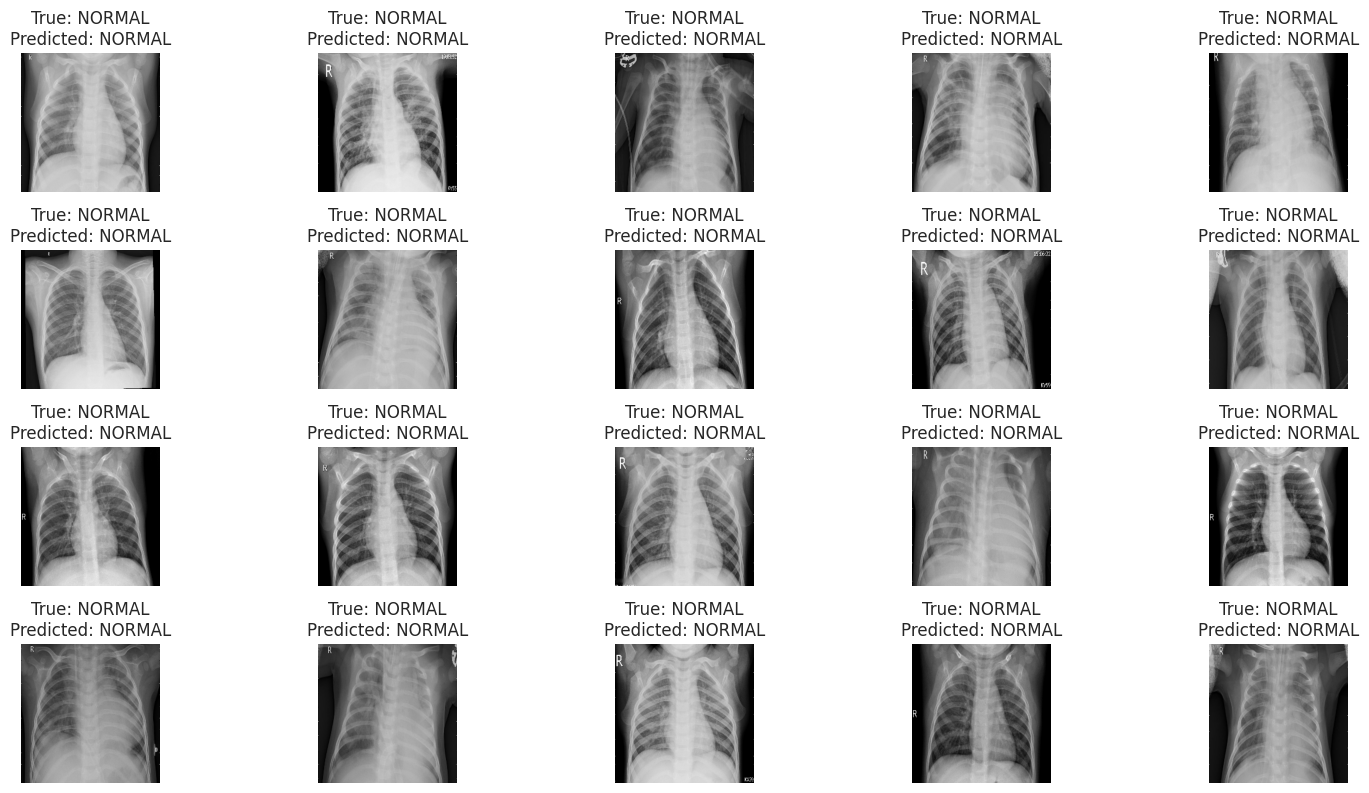

In [21]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

Dado que es un conjunto ligeramente desbalanceado, imprimiremos por pantalla ahora solamente imágenes que están clasificadas como *PNEUMONIA*, para ver cómo se comporta el modelo sobre ellas:

2024-04-27 15:45:01.656370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387127: 5.77154, expected 5.03187
2024-04-27 15:45:01.656429: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387168: 6.05753, expected 5.31786
2024-04-27 15:45:01.656440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387274: 5.79451, expected 5.05483
2024-04-27 15:45:01.656449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387303: 6.3865, expected 5.64683
2024-04-27 15:45:01.656460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387310: 6.3852, expected 5.64553
2024-04-27 15:45:01.656481: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387370: 6.37416, expected 5.63449
2024-04-27 15:45:01.656489: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387381: 4.72788, expected 3.98821
2024-04-27 15:45:01.65

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


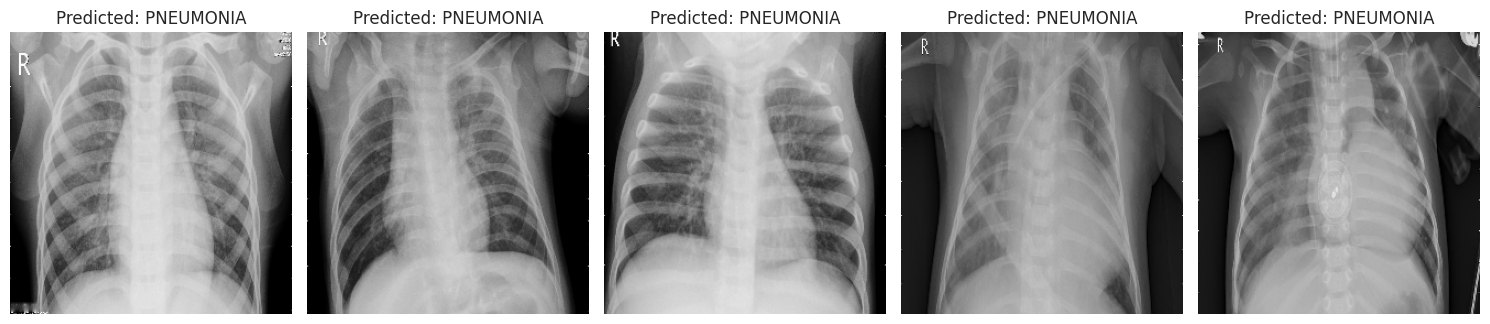

In [22]:
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

image_files = os.listdir(directory_path)[:5]

fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256)) 

    img_array = img.astype(np.float32) / 255.0  

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array);
    actual_prediction = (predictions > 0.5).astype(int);

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

plt.tight_layout()
plt.show()

---
## 2. *Transfer Learning*

El *transfer learning*, es una técnica de aprendizaje automático que consiste en tomar un modelo entrenado en una tarea específica y reutilizarlo como punto de partida para otra tarea relacionada. Se utiliza debido a las siguientes ventajas:

 - **Eficiencia en el Entrenamiento**: Al utilizar un modelo preentrenado, se reduce significativamente el tiempo y los recursos computacionales necesarios para entrenar un nuevo modelo desde cero.
 - **Mejora del Rendimiento**: Los modelos preentrenados ya han aprendido características visuales generales que pueden ser aplicables a nuevas imágenes, lo que puede mejorar la precisión de la clasificación.
 - **Requiere Menos Datos**: Es especialmente valioso cuando no se dispone de grandes conjuntos de datos etiquetados, ya que el modelo ya ha sido entrenado previamente con grandes cantidades de datos.
 - **Generalización**: Los modelos preentrenados tienden a generalizar mejor a nuevos conjuntos de datos, lo que es crucial en el ámbito médico donde cada radiografía puede variar significativamente.
 - **Adaptabilidad**: Permite adaptar modelos a tareas específicas, como distinguir entre radiografías normales y aquellas con signos de neumonía, ajustando solo las últimas capas del modelo para la nueva tarea.

En el contexto de la clasificación de radiografías, el aprendizaje por transferencia permite aprovechar modelos que han sido entrenados con millones de imágenes, incluyendo aquellas fuera del dominio médico, para identificar patrones y anomalías en radiografías con mayor precisión y eficiencia. Esto es particularmente útil para detectar condiciones como la neumonía, donde los signos pueden ser sutiles y difíciles de discernir sin la ayuda de un sistema bien entrenado.

#### Arquitectura

Para empezar utilizamos un *backbone* ya preentrenado. Hemos optado por la arquitectura *Xception*, con los pesos de *imagenet*, ya que hemos visto que son los mejores de cara a la clasificación de imágenes después de un proceso de ensayo y error.

La arquitectura *Xception* esta formada por multitud de convoluciones, poolings, etc... Esta arquitectura es muy avanzada debido a diferentes caracteristicas como
las conexiones de salto, que permiten que la información fluya directamente desde las capas de características anteriores hasta capas posteriores, evitando así la pérdida de información crítica durante el proceso de convolución y agrupación. Estas conexiones de salto ayudan a mitigar el problema de desvanecimiento del gradiente y facilitan el entrenamiento de redes más profundas. Además utilizan capas muy avanzadas como pueden ser las capas *Separable Conv2D* y las capas *Add*.

A esta red esta preentrenada para clasificar en varias categorias, por lo que debemos adaptar su salida a la nuestra. Para ello, le quitaremos las ultimas capas. Se le añadido una MLP, como anteriormente, a la salida modificada, con el fin de classificar si tiene o no nuemonia el paciente segun su radiografia. Esta MLP está compuesta por dos capas densas de 220 y 60 neuronas con un *dropout* de 0.45 y 0.25 respectivamente. La salida de la red es una capa densa de una sola neurona con activacion *sigmoid*, la cual su finalidad es clasificar. Se ha utilizado una funcion de activacion *relu*, en las capas ocultas, debido que es una de las que mejores funcionan en el entremiento, siendo rapida a nivel de cómputo, y ayuda a uno de los principales problemas que tiene estas redes que es el *Vanishing grandient*. La salida de la red es una capa densa de una sola neurona con activacion sigmoid, la cual su finalidad es clasificar. Para la capa de salida, se ha utilizado *sigmoid*, que da como salida una probabilidad entre 0 y 1. Esta activación se utiliza siempre o casi siempre en un clasificador binario como el nuestro, es mera regla su utilización, es la que debemos usar, debido a que es la mas rapida para ello y la que está estipulada. El *Dropout* es una tecnica que nos permitirá no hacer overfitting, y obliga a todas las neuronas a que aprendan y participen, desabilitando neuronas en diferentes mini-baches, calculando los errores y propagando hacia atras.

En el proceso del entrenamiento, la *backbone*, que en nuestro caso es *Xception*, no la entrenaremos, la mantendremos "congelada". No la entrenamos, porque los parametros son muy buenos en si. El coste computacional de entrearlo es muy alto, y solo sería necesario en un paso de *Fine tunning*. Además, para poder entrenarlo, debido a que una parte esta entrenado y la MLP no, tenemos que congelar la *backbone* preentrenada primero, debido al learning rate. Si ponemos un learning rate alto, los pesos de la MLP, se actalizarán rapida mente y de manera correcta, pero los de la *backbone* se modificarn mucho y perderemos la estructura del preentreno. Por ello habria que congelarla y entrenar primero, y porteriormente con una menor *learning rate* y ambos modelos ya entrenamos, hacer el *Fine tunning* si fuese necesario.

Como parametros del entrenamiento hemos ultilizado como optimizador *Adamax*, después de un proceso de ensayo y error, con diferentes optimizadores. *Adamax* es considerado mejor en algunos casos debido a su estabilidad y robustez en términos de tasas de aprendizaje. Especialmente en modelos con grandes parámetros, como el nuestro, Adamax puede tener un mejor rendimiento que Adam. Además, Adamax puede ser más eficiente computacionalmente en términos de memoria, ya que no necesita almacenar los momentos del segundo orden.

Como función de perdida hemos utilizado la *Binary Cross Entropy*. Esta función de pérdida mide la discrepancia entre las distribuciones de probabilidad predichas por el modelo y las distribuciones de probabilidad reales de los datos. Utilizamos esta metrica en problemas de clasificación binaria es porque está diseñada específicamente para manejar salidas binarias (0 o 1).

Por ultimo, para evaluear el modelo hemos optado por usar el *acurracy*. Esta calcula la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas. Se utiliza en problemas de clasificación binaria porque proporciona una visión general del rendimiento del modelo al clasificar correctamente tanto las muestras positivas como las negativas.

Se utilizara *early stopping*, que es una técnica de regularización en el entrenamiento de modelos de aprendizaje automático que detiene el proceso de entrenamiento cuando el rendimiento en un conjunto de validación comienza a deteriorarse, lo que indica un posible sobreajuste. Esto ayuda a encontrar el punto óptimo de entrenamiento donde el modelo generaliza mejor sin ajustarse excesivamente a los datos de entrenamiento. Utilizamos una paciencia de 5 epochs, siendo la paciencia, las epochs en las que no hay cambio, empera o menora minimamente, el entrenamiento, y produce la detención del entrenamiento. Usamos 5 debido a que solo entrenamos 20 epochs. Además este metodo nos permite quedarnos con los mejores pesos, que en las ocasiones en las que el modelo empeora en validación, es muy util. 

Tambien nos permite monitorizar una perdida, mientras el modelo evalua por un acurracy por ejemplo. En nuestro caso el early estopping monitoriza la *validation loss* pero el metodo de evaluacion es *acurracy*.

A continuación se encuentra un esquema gráfico del *backbone* utilizado, *Xception*:

![Exception](https://www.researchgate.net/profile/Abid_Mehmood3/publication/355098045/figure/fig2/AS:1076622409109511@1633698193851/Proposed-structure-of-Xception-network-used-within-each-stream-of-CNN.ppm)


### 2.1 Creamos la arquitectura del modelo

Esquema de la Aquitectura utilizada:
- Xception como backbone.
- Capa BatchNormalization.
- 2 Densas con ativación *relu* y dropout.
- 1 Capa densa de 1 neurona de salida con activación *sigmoid* para la clasificación.

In [23]:
base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      pooling='max', 
                      input_shape=(256, 256, 3))

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())

model.add(Dropout(0.45))
model.add(Dense(220, activation='relu'))

model.add(Dropout(0.25)) 
model.add(Dense(60,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### 2.1 Compilar y Entrenar

Definimos un *early stopping* de cara al entrenamiento de la red neuronal, guardando siempre la mejor ejecución y definiendo una paciencia de 5 *epochs*. 

A continuación, la entrenamos con el conjunto de entrenamiento validando con el de validación:

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds,
                    epochs= 20,
                    validation_data = validation_ds,
                    callbacks = early_stopping)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 57s 260ms/step - accuracy: 0.8853 - loss: 0.2637 - val_accuracy: 0.9539 - val_loss: 0.1241
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9453 - loss: 0.1376 - val_accuracy: 0.9616 - val_loss: 0.0846
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9550 - loss: 0.1125 - val_accuracy: 0.9674 - val_loss: 0.0825
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9598 - loss: 0.0992 - val_accuracy: 0.9674 - val_loss: 0.0763
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.9673 - loss: 0.0852 - val_accuracy: 0.9789 - val_loss: 0.0672
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.9731 - loss: 0.0694 - val_accuracy: 0.9808 - val_loss: 0.0672
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9696 - loss: 0.0769 - val_accuracy: 0.9770 - val_loss: 0.0661
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.9707 - loss: 0

### 2.2 Error de validación y precisión

Obtenemos el error sobre el conjunto de validación y su precisión sobre el mismo:

In [25]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print("Error de validación:", validation_loss)
print("Precisión:", validation_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9870 - loss: 0.0498
Error de validación: 0.06609530001878738
Precisión: 0.9769673943519592


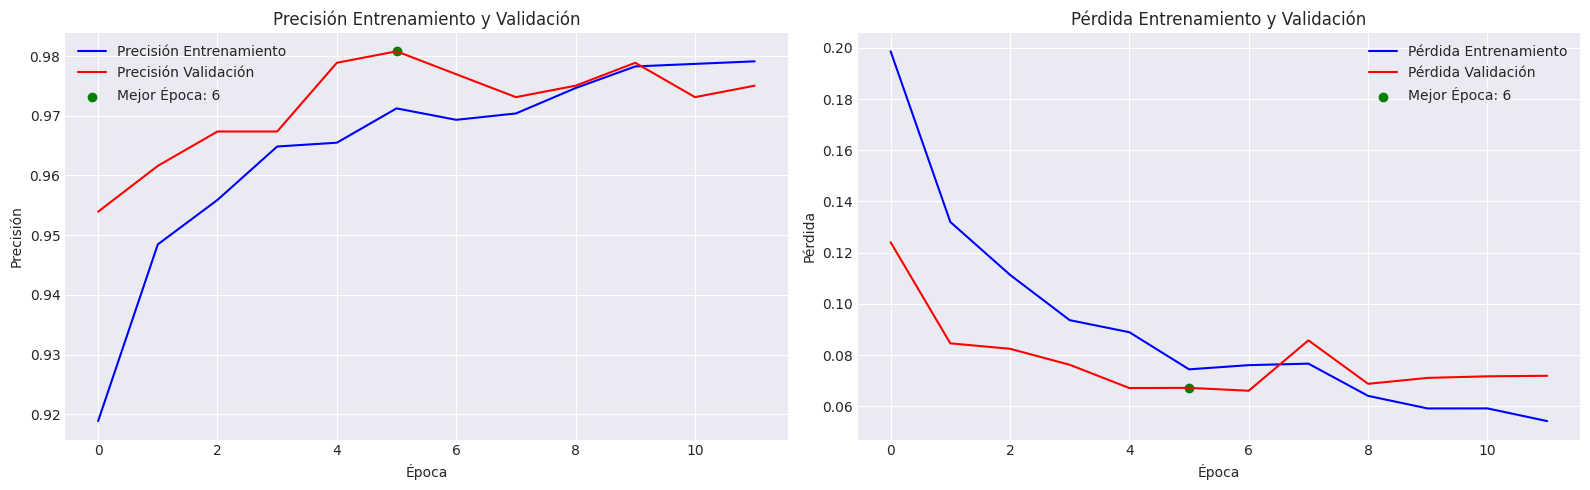

In [26]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Precisión Entrenamiento', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Precisión Validación', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Mejor Época: {best_epoch}')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Precisión')
axs[0].set_title('Precisión Entrenamiento y Validación')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Pérdida Entrenamiento', color='blue')
axs[1].plot(history.history['val_loss'], label='Pérdida Validación', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Mejor Época: {best_epoch}')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Pérdida')
axs[1].set_title('Pérdida Entrenamiento y Validación')
axs[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Predicciones del Modelo

Por último, tomamos una muestra de imágenes del conjunto de test e imprimimos por pantalla tanto las imágenes como las predicciones del modelo.

Para ello, usamos la función definida en el apartado anterior para que nos imprima por pantalla:

Testing Images:
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 437ms/step


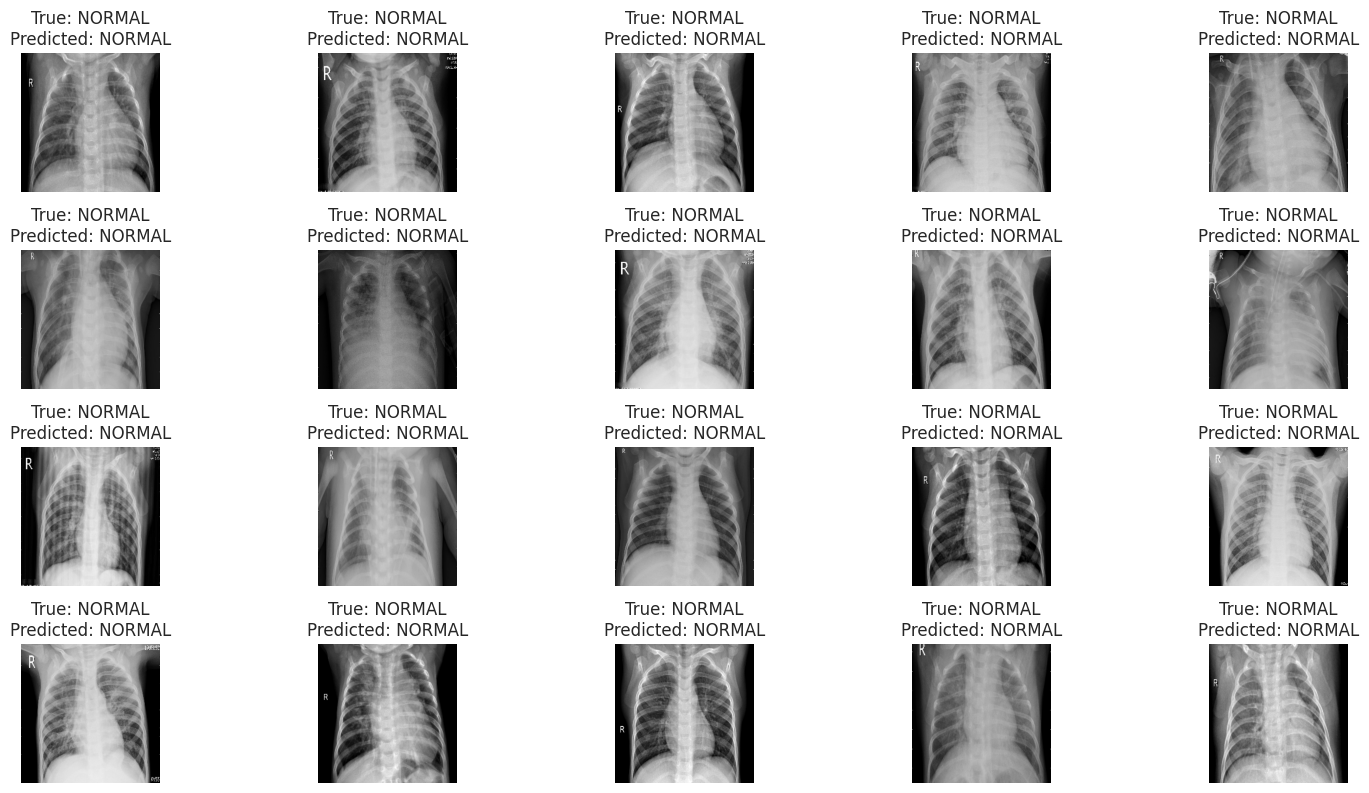

In [27]:
print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

Dado que es un conjunto ligeramente desbalanceado, imprimiremos por pantalla ahora solamente imágenes que están clasificadas como *PNEUMONIA*, para ver cómo se comporta el modelo sobre ellas:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


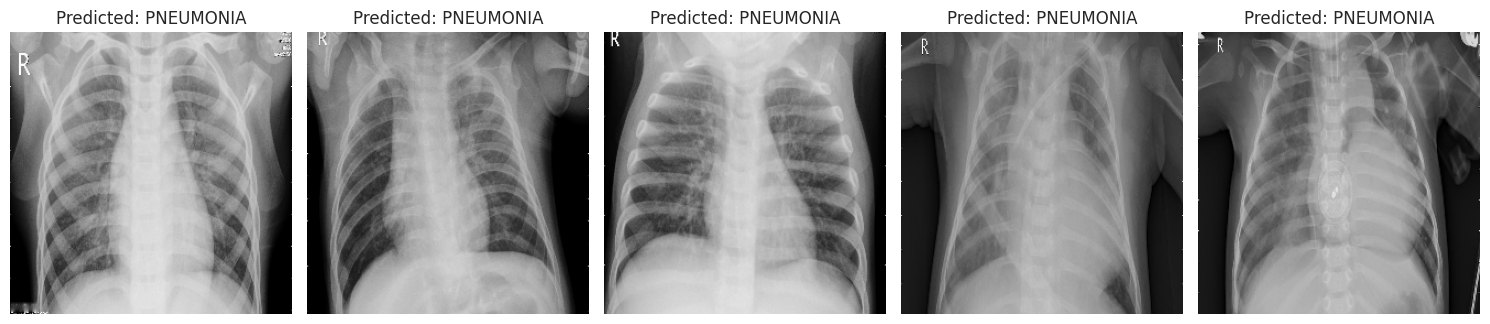

In [28]:
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

image_files = os.listdir(directory_path)[:5]

fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256)) 

    img_array = img.astype(np.float32) / 255.0  

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

plt.tight_layout()
plt.show()

---
# Resultados:

En este ultimo apartado, mostraremos los resultados obtenidos con los diferentes modelos entrenados sobre los mismos datos y adjuntados realizando fine-tunning activo, para posteriormente seleccionar cual es el mejor para esta tarea.

## Tabla de resultados

| Modelo                     | Acurracy del entrenamiento | Error del entrenamiento | Acurracy de validación | Error de validación | Número de parámetros | Comportamiento       |
|----------------------------|----------------------------|-------------------------|------------------------|---------------------|----------------------|----------------------|
| MLP simple     | 0.9364                     | 0.1588                  | 0.9635                 | 0.1018              | 75,516,385 | Bueno                |
| MLP complex                | 0.9094        |  0.1792     |  0.9616                 |  0.1124              | 100,800,417 | Peor                |
| CNN                        | 0.9821                     | 0.0489                  | 0.9827                 | 0.0497              | 6,303,937 | El Mejor             |
| Transfer Learning          | 0.9780                     | 0.0639                  | 0.9770                 | 0.0671              | 20,861,480 | Peor que CNN         |


# Conclusiones

En esta práctica, partimos con la idea de encontrar métodos no solo mejores, sino más eficientes para abordar el problema. Hemos podido contrastar la hipótesis de que las redes neuronales convolucionales son las más adecuadas para el procesamiento de imágenes, como se puede observar en la tabla anterior. Estas redes no solo tienen una fracción de los parámetros de otras arquitecturas, sino que también logran una mayor precisión en el conjunto de pruebas. Además, hemos explorado cómo el transfer learning nos permite obtener resultados aproximados a los de una red convolucional mediante un modelo preentrenado. En resumen, esta estrategia es eficiente para ahorrar costos computacionales y beneficiarse de modelos ya existentes.

Desde un punto de vista práctico, hemos aplicado el conocimiento explicado en clase sobre redes neuronales profundas y convolucionales. Esto nos proporciona una valiosa experiencia para aplicar la inteligencia artificial a problemas cotidianos.

En cuanto a la aplicación médica, hemos definido varios modelos que podrían ser útiles como herramientas de apoyo al diagnóstico. La facilidad de implementación y el alto nivel de precisión hacen que estos modelos sean prometedores. Es importante considerar que, con más tiempo y recursos, podríamos desarrollar un prototipo aún mejor.

A nivel personal, hemos aprendido a aplicar nuestros conocimientos en un caso práctico y a utilizar las herramientas disponibles en Kaggle, como los conjuntos de datos y la potencia de cómputo. En resumen, esta práctica ha sido muy beneficiosa para nuestro desarrollo en el campo del deep learning.

La experiencia de desarrollar y ajustar modelos nos ha enseñado a ser pacientes y perseverantes. Lo normal es que los resultados no sean inmediatos, y que sea necesario un proceso de afinado de hiperparámetros para obtener una solución lo más óptima posible. También hemos aprendido sobre el diagnóstico por imagen y a explorar y experimentar con distintos tipos de arquitectura de cara a un problema. Concretamente, del transfer learning, hemos aprendido a apoyarnos en el trabajo de terceros para poder mejorar nuestros propios modelos predictivos.

En resumen, esta práctica no solo ha fortalecido nuestras habilidades técnicas, sino también nuestra capacidad para enfrentar problemas y aprender de ellos. Esto es indispensable, ya que el deep learning es un campo en constante cambio, donde lo que es el estado del arte puede cambiar rápidamente y esta práctica nos ha aportado una valiosa experiencia en este tipo de desafíos.